**Vehicle Detection Project**

In detail, the goals / steps of this project are the following:

* Performing a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and training a classifier Linear SVM classifier
* Additionally, I also applied a colour transform and appended binned colour features, as well as histograms of colour, to the HOG feature vector. 
* All the features are normalized and the selection for training and testing data is randomized.
* A sliding-window technique is implemented. The trained classifier is used to search for vehicles in images.
* The pipeline is used on a video stream (test_video.mp4 / project_video.mp4). Using a heat map of recurring detections frame by frame helps to reject outliers and follow detected vehicles.
* A bounding box is estimated for vehicles detected.

[//]: # (Image References)
[image1]: ./examples/car_not_car.png
[image2]: ./examples/HOG_example.jpg
[image3]: ./examples/sliding_windows.jpg
[image4]: ./examples/sliding_window.jpg
[image5]: ./examples/bboxes_and_heat.png
[image6]: ./examples/labels_map.png
[image7]: ./examples/output_bboxes.png
[video1]: ./project_video.mp4


---

### Feature extraction

An essential step to detect vehicles in an image is the feature extraction. Besides extracting features from colors (e.g. histogram of the occurence of colors) the Histogram of Oriented Gradients (HOG) is a robust feature which can be used to classify vehicles or non-vehicles.

The code to extract HOG features is contained in the third code cell of the IPython notebook `VehicleDetection.ipynb`.  

There I explored different color spaces and different `skimage.hog()` parameters (`orientations`, `pixels_per_cell`, and `cells_per_block`).  I grabbed random images from each of the two classes and displayed them to get a feel for what the `skimage.hog()` output looks like.

Here is an example using the `YCrCb` color space and HOG parameters of `orientations=8`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)`:


![alt text][image2]

I tried various combinations of parameters for the HOG feature extraction. 
The YUV and YCrCb colorspace performed best. Since the illumination is extracted at these colorspaces, this is not surprising.
The orientation seems to be good if it is greater then 8. 11 diffenent orientations fitted best to my application.
I used 16x16 pixels per cell and 2x2 cells per block. I've determined with a small subset of images to get the best fitting values.


### Create a classifier

I started by reading in all the `vehicle` and `non-vehicle` images. These abeled images were taken from the GTI vehicle image database and the KITTI vision benchmark suite. All images are 64x64 pixels.The database is very important for this project. The given classified database consists of about 9000 non-vehicle and 9000 vehicle images.  Here is an example of one of each of the `vehicle` and `non-vehicle` classes:

![alt text][image1]



All the selected HOG and color features are used to train a classifier.

At the beginning I started with a non-linear SVM and optimized the hyper-parameters using the Scikit Learn GridSearch method.
The test results were quite good with an accuracy above 99%. But later on I had to realize that the results aren't that good on the test images nor at the test video. I faced a kind of overfitting.

From this point I focused more on the dataset. I switched from the non-linear to a linear SVM which can be trained very fast. The features are staight forward enough to seperate them linear to classify a vehicle or a non-vehicle.

To prevent overfitting and to reduce false detections I increased the non-vehicle database by 50% by copying some training images. Further I had to  avoids having nearly identical images in both training and test sets. Therefore, before shuffling the data, I splitted the GTI vehicle image database (which contrains a lot of time-series images) in a test and train set. 

At the end, the classifier has an accuracy of 98% but works even better on the project images / videos then the non-linear SVM.

The classifier and the used hyperparameters are stored in the file `svc_pickle.p` and can be read out using pickle:

```python
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
```


### Sliding Window Search

At this point we have a classifier which is able to predict a vehicle or a non-vehicle from a 64x64 pixel image. To get a correct prediction based on a whole camera image, a method must be found to check all the frames on which a car could be occur.
- Depending on where a car is placed on the image, it appears smaller or bigger. I had to choose different patch sizes and resize them to a 64x64 pixel image.
- Making sure that the performance for scanning on camera image is not too bad, we have to consider that small cars will appear in the horizont region while bigger cars will appear near our camera (at the bottom of the image). This information helps to define the seaching areas for different patches as small as possible. This step does also reduce false detections because we avoid seaching for cars in areas on which no car should occur.
- The sliding window shall overlap to avoid missing vehicles which occur between two patches

I've got the best results, seaching with three different patch sizes: 
- 64x64 pixel patch size
- scaled patch of 0.7 * (64x64 pixel)
- scaled patch of 2.0 * (64x64 pixel)

The patches are overlapping 8 times when sliding through the window. This number is quite high, but it gave the opportunity to eliminate false detections and the processing performance didn't drop much.


![alt text][image3]

### Pipeline and pipeline optimization

Ultimately I searched on two scales using YCrCb 3-channel HOG features plus spatially binned color (16x16) and histograms of color (64) in the feature vector, which provided a nice result.  Here are some example images:

![alt text][image4]

Using the classifier and the sliding window search to predict vehicles the results will be filtered before printing a car label on the given camera image.
Because the sliding window search uses different patches which overlap, one vehicle will be detected more than one time in a camera image. This gives the opportunity to filter out false or non-confidable predictions. 

I recorded the positions of positive detections in each frame of the video.  From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions. 
I then used `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap.  
I then assumed each blob corresponded to a vehicle.  
I constructed bounding boxes to cover the area of each blob detected.  

On the heatmap I implemented a threshold of 4 on each camera image when predicting a vehicle.

Here's an example result showing the heatmap from a series of frames of video, the result of `scipy.ndimage.measurements.label()` and the bounding boxes then overlaid on the last frame of video:
Here are six frames and their corresponding heatmaps:

![alt text][image5]

Here is the output of `scipy.ndimage.measurements.label()` on the integrated heatmap from all six frames:
![alt text][image6]

Here the resulting bounding boxes are drawn onto the last frame in the series:
![alt text][image7]




---

### Video Implementation

Here's a [link to my video result](./project_video.mp4)

To make the prediction more robust and to get a smoothier label for predicted vehicles, a camera image frame overlapping filter is used. Using 8 Frames, and a further threshold of 28 (sum of overlapping vehicle predictions over 8 frames) makes sure that false predictions are prevented. Additionally it helps to avoid flicking labels, even if there are one or two single frames on which a car isn't recognized at all.


---

### Discussion
Where will your pipeline likely fail?  What could you do to make it more robust?
Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further.  



In [1]:
DEBUG = False

import matplotlib.image as mpimg
import numpy as np
import cv2
from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as patches
if DEBUG:
    import matplotlib.pyplot as plt




# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)



# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)
        #image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=False)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    #draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,576:1280,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    window_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                window_list.append(((xbox_left+576, ytop_draw+ystart), (xbox_left+576+win_draw,ytop_draw+win_draw+ystart)))

    if DEBUG:
        print("boxes found: ", len(window_list), " (size: ", scale, ")")
    return window_list


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def update_heat(heatmap, heatmapToAdd):
    heatmap = np.add(heatmap, heatmapToAdd)
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def pipeline_vehicleDetection(img):
    box_list = []
    box_list_temp = []
    box_list.extend(find_cars(img, 350, 500, 0.7, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    box_list.extend(find_cars(img, 370, 550, 1.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    box_list_temp = find_cars(img, 350, 720, 2.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    box_list.extend(box_list_temp)
    #box_list.extend(box_list_temp)

    if DEBUG == True:
        #img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        draw_img = np.copy(img)
        for box in box_list:
            cv2.rectangle(draw_img,box[0], box[1],(0,0,255),6)

        plt.imshow(draw_img)
        plt.show()
        
        #fig = plt.figure(figsize=(20,14))
        #plt.subplot(121)
        #plt.imshow(draw_img)
        #plt.title('Car Positions')
        #plt.subplot(122)
        #plt.imshow(heatmap, cmap='hot')
        #plt.title('Heat Map')
        #fig.tight_layout()
        #plt.subplot_tool()
        #plt.show()
    
    
    CarPred.update_current(box_list)
    labels = CarPred.get_labels()
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img



class CarPrediction():
    def __init__(self, n_frames = 10, heatbox_threshold = 10, local_heatbox_threshold = 1, img_size = (1720, 1280)):
    
        # number of frames from which the vehicle predictions are stored
        self.n_frames = n_frames
        # heatbox threshold for sum of all images (n_frames)
        self.heatbox_threshold = heatbox_threshold
        # heatbox threshold for each image
        self.local_heatbox_threshold = local_heatbox_threshold
        # boxes on which a vehicle is predicted on the current frame
        self.current_boxes = []
        # boxes on which a vehicle is predicted stored for each of the previous frames (n_frames)
        self.boxes_per_frame = []
        
        self.img_size = img_size
        
        self.labels = []

        
    def update_current(self, current_boxes):
        """
        Updates the boxes (rectangle coordinates) which predict a car to be there (for the current frame)
        :param current_boxes: list of rectangles (x_left, y_upper),(x_right, y_bottom)
        """
        self.current_boxes = current_boxes

        if len(self.boxes_per_frame) > self.n_frames:
            self.boxes_per_frame.pop(0)
        self.boxes_per_frame.append(self.current_boxes)

    def get_all_boxes(self):
        box_list = []
        for boxes in self.boxes_per_frame:
            box_list.extend(boxes)
        return box_list
    
    def get_labels(self):
        output_heatmap = np.zeros(self.img_size).astype(np.float)
        for boxes in self.boxes_per_frame:
            heatmap = np.zeros(self.img_size).astype(np.float)
            heatmap = add_heat(heatmap, boxes)
            
            if self.local_heatbox_threshold > 0:
                heatmap = apply_threshold(heatmap, self.local_heatbox_threshold)
            
            output_heatmap = update_heat(output_heatmap, heatmap)
        
        if self.heatbox_threshold > 0:
                output_heatmap = apply_threshold(output_heatmap, self.heatbox_threshold)
        
        # Find final boxes from heatmap using label function
        self.labels = label(output_heatmap)
        return self.labels

In [ ]:
from sklearn.model_selection import train_test_split
import glob
import random

# Read in car and non-car images
images = glob.glob('vehicles/**/*.png')
if DEBUG:
    print(type(images))

rand_state = np.random.randint(0, len(images))

spatial = 16
histbin = 64


randIndex = random.randint(0,len(images)-1)
img_cv2 = cv2.imread(images[randIndex])
img_mpimg = mpimg.imread(images[randIndex])

print("cv2 png")
print(type(img_cv2))
print(img_cv2)
print("yuv_img_cv2")
yuv_img_cv2 = cv2.cvtColor(img_cv2, cv2.COLOR_RGB2YUV)
print(yuv_img_cv2)

print("mpimg png")
print(type(img_mpimg))
print(img_mpimg)
print("yuv_img_mpimg")
yuv_img_mpimg = cv2.cvtColor(img_mpimg, cv2.COLOR_RGB2YUV)
print(yuv_img_mpimg)

imagess = []
imagess.append(img_mpimg)
imagess.append(img_cv2)

car_features = single_img_features(yuv_img_cv2, color_space='YUV', spatial_size=(spatial, spatial),
                        hist_bins=histbin, orient=11, 
                        pix_per_cell=16, cell_per_block=2, hog_channel="ALL",
                        spatial_feat=True, hist_feat=True, hog_feat=True)

car_features2 = single_img_features(yuv_img_mpimg, color_space='YUV', spatial_size=(spatial, spatial),
                        hist_bins=histbin, orient=11, 
                        pix_per_cell=16, cell_per_block=2, hog_channel="ALL",
                        spatial_feat=True, hist_feat=True, hog_feat=True)

print("car features")
print(type(car_features))
print(car_features)

print("car features2")
print(type(car_features))
print(car_features2)

from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold
import pylab as pl

#C_range = 10. ** np.arange(-3, 8)
#gamma_range = 10. ** np.arange(-5, 4)
#param_grid = dict(gamma=gamma_range, C=C_range)
#grid = GridSearchCV(SVC(), param_grid=param_grid, cv=StratifiedKFold(y=y_train, n_folds=5))
#grid.fit(X_train, y_train)
#print("The best classifier is: ", grid.best_estimator_)
# plot the scores of the grid
# grid_scores_ contains parameter settings and scores
#score_dict = grid.grid_scores_
# We extract just the scores
#scores = [x[1] for x in score_dict]
#scores = np.array(scores).reshape(len(C_range), len(gamma_range))
# Make a nice figure
#pl.figure(figsize=(8, 6))
#pl.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
#pl.imshow(scores, interpolation='nearest', cmap=pl.cm.spectral)
#pl.xlabel('gamma')
#pl.ylabel('C')
#pl.colorbar()
#pl.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
#pl.yticks(np.arange(len(C_range)), C_range)
#pl.show()

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
import glob
import time
import numpy as np

# 1. Performing a Histogram of Oriented Gradients (HOG) feature extraction on a
#  labeled training set of images and training a classifier Linear SVM classifier

# Additionally, I also applied a colour transform and appended binned colour features, as well as histograms of colour, to the HOG feature vector. 
# All the features are normalized and the selection for training and testing data is randomized.

# Read in car and non-car images
images_nonvehicle = glob.glob('non-vehicles/**/*.png')
notcars_train = images_nonvehicle[0 : int(len(images_nonvehicle) * .80)]
notcars_test = images_nonvehicle [int(len(images_nonvehicle) * .80) : len(images_nonvehicle)]

images_vehicle = glob.glob('vehicles/**/*.png')
cars_train = images_vehicle[0 : int(len(images_vehicle) * .80)]
cars_test = images_vehicle [int(len(images_vehicle) * .80) : len(images_vehicle)]

# TODO play with these values to see how your classifier
# performs under different binning scenarios
spatial_size = (16,16)
histbin = 64
pix_per_cell = 16
cell_per_block = 2
orient = 11

car_features_train = extract_features(cars_train, color_space='YCrCb', spatial_size=spatial_size,
                        hist_bins=histbin, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel="ALL",
                        spatial_feat=True, hist_feat=True, hog_feat=True)
notcar_features_train = extract_features(notcars_train, color_space='YCrCb', spatial_size=spatial_size,
                        hist_bins=histbin, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel="ALL",
                        spatial_feat=True, hist_feat=True, hog_feat=True)

car_features_test = extract_features(cars_test, color_space='YCrCb', spatial_size=spatial_size,
                        hist_bins=histbin, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel="ALL",
                        spatial_feat=True, hist_feat=True, hog_feat=True)
notcar_features_test = extract_features(notcars_test, color_space='YCrCb', spatial_size=spatial_size,
                        hist_bins=histbin, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel="ALL",
                        spatial_feat=True, hist_feat=True, hog_feat=True)


# Create an array stack of feature vectors
X_trainset = np.vstack((car_features_train, notcar_features_train)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler_trainset = StandardScaler().fit(X_trainset)
# Apply the scaler to X
scaled_X_trainset = X_scaler_trainset.transform(X_trainset)
# Define the labels vector
y_trainset = np.hstack((np.ones(len(car_features_train)), np.zeros(len(notcar_features_train))))

# Create an array stack of feature vectors
X_testset = np.vstack((car_features_test, notcar_features_test)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler_testset = StandardScaler().fit(X_testset)
# Apply the scaler to X
scaled_X_testset = X_scaler_testset.transform(X_testset)
# Define the labels vector
y_testset = np.hstack((np.ones(len(car_features_test)), np.zeros(len(notcar_features_test))))

# Split up data into randomized training sets
rand_state = np.random.randint(0, 100)
X_train, dummyx, y_train, dummyy = train_test_split(
    scaled_X_trainset, y_trainset, test_size=0, random_state=rand_state)
print(len(X_train))
print(len(y_train))
# Split up data into randomized test sets
X_test, dummyx , y_test, dummyy  = train_test_split(
    scaled_X_testset, y_testset, test_size=0, random_state=rand_state)

print('Using spatial binning of:',spatial_size,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))


# Use a linear SVC 
#svc = SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
#  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
#  max_iter=-1, probability=False, random_state=None, shrinking=True,
#  tol=0.001, verbose=False)

svc= LinearSVC(C=0.00001)

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

dist_pickle = {}
dist_pickle["svc"] = svc
dist_pickle["scaler"] = X_scaler_trainset
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["spatial_size"] = spatial_size
dist_pickle["hist_bins"] = histbin

with open("svc_pickle.p", "wb") as f:
    pickle.dump(dist_pickle, f)

print("SVC and parameters stored")


C:\Users\Elias\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


18261
18261
Using spatial binning of: (16, 16) and 64 histogram bins
Feature vector length: 2148
1.74 Seconds to train SVC...
Test Accuracy of SVC =  0.9801
SVC and parameters stored


boxes found:  37  (size:  0.7 )
boxes found:  36  (size:  1.0 )
boxes found:  10  (size:  2.0 )
boxes found:  0  (size:  0.4 )


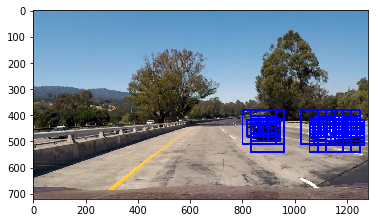

boxes found:  0  (size:  0.7 )
boxes found:  0  (size:  1.0 )
boxes found:  0  (size:  2.0 )
boxes found:  2  (size:  0.4 )


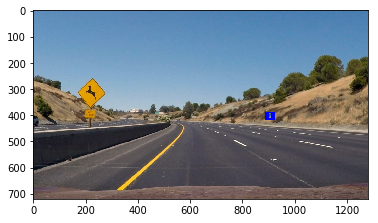

boxes found:  3  (size:  0.7 )
boxes found:  3  (size:  1.0 )
boxes found:  0  (size:  2.0 )
boxes found:  0  (size:  0.4 )


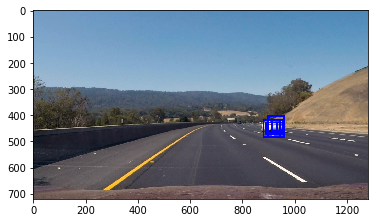

boxes found:  43  (size:  0.7 )
boxes found:  36  (size:  1.0 )
boxes found:  11  (size:  2.0 )
boxes found:  1  (size:  0.4 )


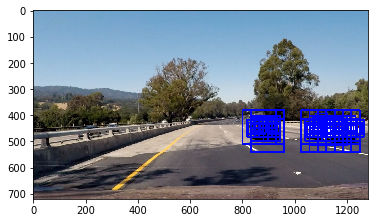

boxes found:  33  (size:  0.7 )
boxes found:  23  (size:  1.0 )
boxes found:  7  (size:  2.0 )
boxes found:  2  (size:  0.4 )


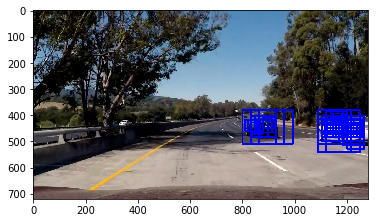

boxes found:  31  (size:  0.7 )
boxes found:  29  (size:  1.0 )
boxes found:  10  (size:  2.0 )
boxes found:  0  (size:  0.4 )


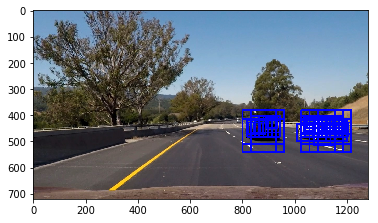

In [15]:
# Manual pipeline with prints and plots
from sklearn.preprocessing import StandardScaler
import pickle
import random
from sklearn.svm import LinearSVC
import glob
from scipy.ndimage.measurements import label
import matplotlib.patches as patches
import matplotlib.pyplot as plt

dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

# Make a list of calibration images 
images = glob.glob('test_images/*.jpg')
# images = glob.glob('frames_video/*.jpg')
randIndex = random.randint(0,len(images)-1)
#img = cv2.imread(images[randIndex])
for image in images:
    img = cv2.imread(image)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    CarPred = CarPrediction(8,28,4,(1720, 1280))
    output_img = pipeline_vehicleDetection(img_rgb)


# defining source points for transforming image


# 2. A sliding-window technique is implemented. The trained classifier is used to search for vehicles in images.
#imshape = img.shape
#y_size = imshape[0]
#ystart = (350)
#ystop = (700)
#scale = 1

#box_list = []
#window_list = slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
#                    xy_window=(64, 64), xy_overlap=(0.75, 0.75))

#box_list.extend(find_cars(img, 350, 460, 0.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
#box_list.extend(find_cars(img, 350, 550, 1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
#box_list.extend(find_cars(img, 350, 720, 1.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
#box_list.extend(find_cars(img, 330, 720, 2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
#box_list.extend(find_cars(img, 320, 720, 8, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

#img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#draw_img = np.copy(img_rgb)
#for box in box_list:
#    cv2.rectangle(draw_img,box[0], box[1],(0,0,255),6)

#plt.imshow(draw_img)
#plt.show()

#heat = np.zeros_like(img[:,:,0]).astype(np.float)
# Add heat to each box in box list
#heat = add_heat(heat,box_list)
# Apply threshold to help remove false positives
#heat = apply_threshold(heat,1)
# Visualize the heatmap when displaying    
#heatmap = np.clip(heat, 0, 255)
# Find final boxes from heatmap using label function
#labels = label(heatmap)

#print(labels[1], 'cars found')
#plt.imshow(labels[0], cmap='gray')
#plt.show()

#draw_img = draw_labeled_bboxes(np.copy(img_rgb), labels)

#fig = plt.figure(figsize=(20,14))
#plt.subplot(121)
#plt.imshow(draw_img)
#plt.title('Car Positions')
#plt.subplot(122)
#plt.imshow(heatmap, cmap='hot')
#plt.title('Heat Map')
#fig.tight_layout()
#plt.subplot_tool()
#plt.show()
# The pipeline is used on a video stream (test_video.mp4 / project_video.mp4). Using a heat map of recurring detections frame by frame helps to reject outliers and follow detected vehicles.
# A bounding box is estimated for vehicles detected.

In [2]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pickle

dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

CarPred = CarPrediction(8,28,4,(720, 1280))

white_output = 'output_video/8_28_4_project_video_whole.mp4'
#white_output = 'output_video/test_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("test_video.mp4")
print(clip1.fps)
white_clip = clip1.fl_image(pipeline_vehicleDetection) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

25.0
[MoviePy] >>>> Building video output_video/8_28_4_project_video_whole.mp4
[MoviePy] Writing video output_video/8_28_4_project_video_whole.mp4


100%|█████████████████████████████████████▉| 1260/1261 [39:44<00:01,  1.89s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/8_28_4_project_video_whole.mp4 

Wall time: 39min 45s


In [ ]:
features.append(single_img_features(...))